<a href="https://colab.research.google.com/github/AgustinCocciardi/IA-Aplicada/blob/main/06_Modelo_Word2Vec_preentrenado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline


Word2Vec Model
==============

Introduces Gensim's Word2Vec model and demonstrates its use on the `Lee Evaluation Corpus
<https://hekyll.services.adelaide.edu.au/dspace/bitstream/2440/28910/1/hdl_28910.pdf>`_.



In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In case you missed the buzz, Word2Vec is a widely used algorithm based on neural
networks, commonly referred to as "deep learning" (though word2vec itself is rather shallow).
Using large amounts of unannotated plain text, word2vec learns relationships
between words automatically. The output are vectors, one vector per word,
with remarkable linear relationships that allow us to do things like:

* vec("king") - vec("man") + vec("woman") =~ vec("queen")
* vec("Montreal Canadiens") – vec("Montreal") + vec("Toronto") =~ vec("Toronto Maple Leafs").

Word2vec is very useful in `automatic text tagging
<https://github.com/RaRe-Technologies/movie-plots-by-genre>`_\ , recommender
systems and machine translation.

This tutorial:

#. Introduces ``Word2Vec`` as an improvement over traditional bag-of-words
#. Shows off a demo of ``Word2Vec`` using a pre-trained model
#. Demonstrates training a new model from your own data
#. Demonstrates loading and saving models
#. Introduces several training parameters and demonstrates their effect
#. Discusses memory requirements
#. Visualizes Word2Vec embeddings by applying dimensionality reduction

Review: Bag-of-words
--------------------

.. Note:: Feel free to skip these review sections if you're already familiar with the models.

You may be familiar with the `bag-of-words model
<https://en.wikipedia.org/wiki/Bag-of-words_model>`_ from the
`core_concepts_vector` section.
This model transforms each document to a fixed-length vector of integers.
For example, given the sentences:

- ``John likes to watch movies. Mary likes movies too.``
- ``John also likes to watch football games. Mary hates football.``

The model outputs the vectors:

- ``[1, 2, 1, 1, 2, 1, 1, 0, 0, 0, 0]``
- ``[1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 1]``

Each vector has 10 elements, where each element counts the number of times a
particular word occurred in the document.
The order of elements is arbitrary.
In the example above, the order of the elements corresponds to the words:
``["John", "likes", "to", "watch", "movies", "Mary", "too", "also", "football", "games", "hates"]``.

Bag-of-words models are surprisingly effective, but have several weaknesses.

First, they lose all information about word order: "John likes Mary" and
"Mary likes John" correspond to identical vectors. There is a solution: bag
of `n-grams <https://en.wikipedia.org/wiki/N-gram>`__
models consider word phrases of length n to represent documents as
fixed-length vectors to capture local word order but suffer from data
sparsity and high dimensionality.

Second, the model does not attempt to learn the meaning of the underlying
words, and as a consequence, the distance between vectors doesn't always
reflect the difference in meaning.  The ``Word2Vec`` model addresses this
second problem.

Introducing: the ``Word2Vec`` Model
-----------------------------------

``Word2Vec`` is a more recent model that embeds words in a lower-dimensional
vector space using a shallow neural network. The result is a set of
word-vectors where vectors close together in vector space have similar
meanings based on context, and word-vectors distant to each other have
differing meanings. For example, ``strong`` and ``powerful`` would be close
together and ``strong`` and ``Paris`` would be relatively far.

The are two versions of this model and :py:class:`~gensim.models.word2vec.Word2Vec`
class implements them both:

1. Skip-grams (SG)
2. Continuous-bag-of-words (CBOW)

.. Important::
  Don't let the implementation details below scare you.
  They're advanced material: if it's too much, then move on to the next section.

The `Word2Vec Skip-gram <http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model>`__
model, for example, takes in pairs (word1, word2) generated by moving a
window across text data, and trains a 1-hidden-layer neural network based on
the synthetic task of given an input word, giving us a predicted probability
distribution of nearby words to the input. A virtual `one-hot
<https://en.wikipedia.org/wiki/One-hot>`__ encoding of words
goes through a 'projection layer' to the hidden layer; these projection
weights are later interpreted as the word embeddings. So if the hidden layer
has 300 neurons, this network will give us 300-dimensional word embeddings.

Continuous-bag-of-words Word2vec is very similar to the skip-gram model. It
is also a 1-hidden-layer neural network. The synthetic training task now uses
the average of multiple input context words, rather than a single word as in
skip-gram, to predict the center word. Again, the projection weights that
turn one-hot words into averageable vectors, of the same width as the hidden
layer, are interpreted as the word embeddings.




Word2Vec Demo
-------------

To see what ``Word2Vec`` can do, let's download a pre-trained model and play
around with it. We will fetch the Word2Vec model trained on part of the
Google News dataset, covering approximately 3 million words and phrases. Such
a model can take hours to train, but since it's already available,
downloading and loading it with Gensim takes minutes.

.. Important::
  The model is approximately 2GB, so you'll need a decent network connection
  to proceed.  Otherwise, skip ahead to the "Training Your Own Model" section
  below.

You may also check out an `online word2vec demo
<http://radimrehurek.com/2014/02/word2vec-tutorial/#app>`_ where you can try
this vector algebra for yourself. That demo runs ``word2vec`` on the
**entire** Google News dataset, of **about 100 billion words**.




In [3]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

[==============================--------------------] 61.4% 1021.3/1662.8MB downloaded

ContentTooShortError: <urlopen error retrieval incomplete: got only 1070890844 out of 1743563840 bytes>

A common operation is to retrieve the vocabulary of a model. That is trivial:



In [ ]:
for index, word in enumerate(wv.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(wv.index_to_key)} is {word}")

word #0/3000000 is </s>
word #1/3000000 is in
word #2/3000000 is for
word #3/3000000 is that
word #4/3000000 is is
word #5/3000000 is on
word #6/3000000 is ##
word #7/3000000 is The
word #8/3000000 is with
word #9/3000000 is said


We can easily obtain vectors for terms the model is familiar with:




In [ ]:
vec_king = wv['king']

Unfortunately, the model is unable to infer vectors for unfamiliar words.
This is one limitation of Word2Vec: if this limitation matters to you, check
out the FastText model.




In [ ]:
try:
    vec_cameroon = wv['cameroon']
except KeyError:
    print("The word 'cameroon' does not appear in this model")

The word 'cameroon' does not appear in this model


Moving on, ``Word2Vec`` supports several word similarity tasks out of the
box.  You can see how the similarity intuitively decreases as the words get
less and less similar.




In [ ]:
pairs = [
    ('car', 'minivan'),   # a minivan is a kind of car
    ('car', 'bicycle'),   # still a wheeled vehicle
    ('car', 'airplane'),  # ok, no wheels, but still a vehicle
    ('car', 'cereal'),    # ... and so on
    ('car', 'communism'),
]
for w1, w2 in pairs:
    print('%r\t%r\t%.2f' % (w1, w2, wv.similarity(w1, w2)))

'car'	'minivan'	0.69
'car'	'bicycle'	0.54
'car'	'airplane'	0.42
'car'	'cereal'	0.14
'car'	'communism'	0.06


Print the 5 most similar words to "car" or "minivan"



In [ ]:
print(wv.most_similar(positive=['car', 'minivan'], topn=5))

[('SUV', 0.8532192707061768), ('vehicle', 0.8175783753395081), ('pickup_truck', 0.7763688564300537), ('Jeep', 0.7567334175109863), ('Ford_Explorer', 0.7565720081329346)]


Which of the below does not belong in the sequence?



In [ ]:
print(wv.doesnt_match(['fire', 'water', 'land', 'sea', 'air', 'car']))

car


Training Your Own Model
-----------------------

To start, you'll need some data for training the model. For the following
examples, we'll use the `Lee Evaluation Corpus
<https://hekyll.services.adelaide.edu.au/dspace/bitstream/2440/28910/1/hdl_28910.pdf>`_
(which you `already have
<https://github.com/RaRe-Technologies/gensim/blob/develop/gensim/test/test_data/lee_background.cor>`_
if you've installed Gensim).

This corpus is small enough to fit entirely in memory, but we'll implement a
memory-friendly iterator that reads it line-by-line to demonstrate how you
would handle a larger corpus.




In [10]:
from gensim.test.utils import datapath
from gensim import utils

class MyCorpus:
    """An iterator that yields sentences (lists of str)."""

    def __iter__(self):
        corpus_path = datapath('lee_background.cor')
        for line in open(corpus_path):
            # assume there's one document per line, tokens separated by whitespace
            yield utils.simple_preprocess(line)

If we wanted to do any custom preprocessing, e.g. decode a non-standard
encoding, lowercase, remove numbers, extract named entities... All of this can
be done inside the ``MyCorpus`` iterator and ``word2vec`` doesn’t need to
know. All that is required is that the input yields one sentence (list of
utf8 words) after another.

Let's go ahead and train a model on our corpus.  Don't worry about the
training parameters much for now, we'll revisit them later.




In [11]:
import gensim.models

sentences = MyCorpus()
model = gensim.models.Word2Vec(sentences=sentences)

Once we have our model, we can use it in the same way as in the demo above.

The main part of the model is ``model.wv``\ , where "wv" stands for "word vectors".




In [12]:
vec_king = model.wv['king']

Retrieving the vocabulary works the same way:



In [13]:
for index, word in enumerate(wv.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(wv.index_to_key)} is {word}")

NameError: name 'wv' is not defined

Storing and loading models
--------------------------

You'll notice that training non-trivial models can take time.  Once you've
trained your model and it works as expected, you can save it to disk.  That
way, you don't have to spend time training it all over again later.

You can store/load models using the standard gensim methods:




In [14]:
import tempfile

with tempfile.NamedTemporaryFile(prefix='gensim-model-', delete=False) as tmp:
    temporary_filepath = tmp.name
    model.save(temporary_filepath)
    #
    # The model is now safely stored in the filepath.
    # You can copy it to other machines, share it with others, etc.
    #
    # To load a saved model:
    #
    new_model = gensim.models.Word2Vec.load(temporary_filepath)

which uses pickle internally, optionally ``mmap``\ ‘ing the model’s internal
large NumPy matrices into virtual memory directly from disk files, for
inter-process memory sharing.

In addition, you can load models created by the original C tool, both using
its text and binary formats::

  model = gensim.models.KeyedVectors.load_word2vec_format('/tmp/vectors.txt', binary=False)
  # using gzipped/bz2 input works too, no need to unzip
  model = gensim.models.KeyedVectors.load_word2vec_format('/tmp/vectors.bin.gz', binary=True)




Training Parameters
-------------------

``Word2Vec`` accepts several parameters that affect both training speed and quality.

min_count
---------

``min_count`` is for pruning the internal dictionary. Words that appear only
once or twice in a billion-word corpus are probably uninteresting typos and
garbage. In addition, there’s not enough data to make any meaningful training
on those words, so it’s best to ignore them:

default value of min_count=5



In [15]:
model = gensim.models.Word2Vec(sentences, min_count=10)

vector_size
-----------

``vector_size`` is the number of dimensions (N) of the N-dimensional space that
gensim Word2Vec maps the words onto.

Bigger size values require more training data, but can lead to better (more
accurate) models. Reasonable values are in the tens to hundreds.




In [16]:
# The default value of vector_size is 100.
model = gensim.models.Word2Vec(sentences, vector_size=200)

workers
-------

``workers`` , the last of the major parameters (full list `here
<http://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec>`_)
is for training parallelization, to speed up training:




In [17]:
# default value of workers=3 (tutorial says 1...)
model = gensim.models.Word2Vec(sentences, workers=4)

The ``workers`` parameter only has an effect if you have `Cython
<http://cython.org/>`_ installed. Without Cython, you’ll only be able to use
one core because of the `GIL
<https://wiki.python.org/moin/GlobalInterpreterLock>`_ (and ``word2vec``
training will be `miserably slow
<http://rare-technologies.com/word2vec-in-python-part-two-optimizing/>`_\ ).




Memory
------

At its core, ``word2vec`` model parameters are stored as matrices (NumPy
arrays). Each array is **#vocabulary** (controlled by the ``min_count`` parameter)
times **vector size** (the ``vector_size`` parameter) of floats (single precision aka 4 bytes).

Three such matrices are held in RAM (work is underway to reduce that number
to two, or even one). So if your input contains 100,000 unique words, and you
asked for layer ``vector_size=200``\ , the model will require approx.
``100,000*200*4*3 bytes = ~229MB``.

There’s a little extra memory needed for storing the vocabulary tree (100,000 words would
take a few megabytes), but unless your words are extremely loooong strings, memory
footprint will be dominated by the three matrices above.




Evaluating
----------

``Word2Vec`` training is an unsupervised task, there’s no good way to
objectively evaluate the result. Evaluation depends on your end application.

Google has released their testing set of about 20,000 syntactic and semantic
test examples, following the “A is to B as C is to D” task. It is provided in
the 'datasets' folder.

For example a syntactic analogy of comparative type is ``bad:worse;good:?``.
There are total of 9 types of syntactic comparisons in the dataset like
plural nouns and nouns of opposite meaning.

The semantic questions contain five types of semantic analogies, such as
capital cities (``Paris:France;Tokyo:?``) or family members
(``brother:sister;dad:?``).




Gensim supports the same evaluation set, in exactly the same format:




In [18]:
model.wv.evaluate_word_analogies(datapath('questions-words.txt'))

(0.0,
 [{'section': 'capital-common-countries',
   'correct': [],
   'incorrect': [('CANBERRA', 'AUSTRALIA', 'KABUL', 'AFGHANISTAN'),
    ('CANBERRA', 'AUSTRALIA', 'PARIS', 'FRANCE'),
    ('KABUL', 'AFGHANISTAN', 'PARIS', 'FRANCE'),
    ('KABUL', 'AFGHANISTAN', 'CANBERRA', 'AUSTRALIA'),
    ('PARIS', 'FRANCE', 'CANBERRA', 'AUSTRALIA'),
    ('PARIS', 'FRANCE', 'KABUL', 'AFGHANISTAN')]},
  {'section': 'capital-world',
   'correct': [],
   'incorrect': [('CANBERRA', 'AUSTRALIA', 'KABUL', 'AFGHANISTAN'),
    ('KABUL', 'AFGHANISTAN', 'PARIS', 'FRANCE')]},
  {'section': 'currency', 'correct': [], 'incorrect': []},
  {'section': 'city-in-state', 'correct': [], 'incorrect': []},
  {'section': 'family',
   'correct': [],
   'incorrect': [('HE', 'SHE', 'HIS', 'HER'),
    ('HE', 'SHE', 'MAN', 'WOMAN'),
    ('HIS', 'HER', 'MAN', 'WOMAN'),
    ('HIS', 'HER', 'HE', 'SHE'),
    ('MAN', 'WOMAN', 'HE', 'SHE'),
    ('MAN', 'WOMAN', 'HIS', 'HER')]},
  {'section': 'gram1-adjective-to-adverb', 'correct': [

This ``evaluate_word_analogies`` method takes an `optional parameter
<http://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.evaluate_word_analogies>`_
``restrict_vocab`` which limits which test examples are to be considered.




In the December 2016 release of Gensim we added a better way to evaluate semantic similarity.

By default it uses an academic dataset WS-353 but one can create a dataset
specific to your business based on it. It contains word pairs together with
human-assigned similarity judgments. It measures the relatedness or
co-occurrence of two words. For example, 'coast' and 'shore' are very similar
as they appear in the same context. At the same time 'clothes' and 'closet'
are less similar because they are related but not interchangeable.




In [19]:
model.wv.evaluate_word_pairs(datapath('wordsim353.tsv'))

(PearsonRResult(statistic=0.10622784431997101, pvalue=0.41919563833560164),
 SignificanceResult(statistic=0.1065443941555204, pvalue=0.4178030917428682),
 83.0028328611898)

.. Important::
  Good performance on Google's or WS-353 test set doesn’t mean word2vec will
  work well in your application, or vice versa. It’s always best to evaluate
  directly on your intended task. For an example of how to use word2vec in a
  classifier pipeline, see this `tutorial
  <https://github.com/RaRe-Technologies/movie-plots-by-genre>`_.




Online training / Resuming training
-----------------------------------

Advanced users can load a model and continue training it with more sentences
and `new vocabulary words <online_w2v_tutorial.ipynb>`_:




In [20]:
model = gensim.models.Word2Vec.load(temporary_filepath)
more_sentences = [
    ['Advanced', 'users', 'can', 'load', 'a', 'model',
     'and', 'continue', 'training', 'it', 'with', 'more', 'sentences'],
]
model.build_vocab(more_sentences, update=True)
model.train(more_sentences, total_examples=model.corpus_count, epochs=model.epochs)

# cleaning up temporary file
import os
os.remove(temporary_filepath)

You may need to tweak the ``total_words`` parameter to ``train()``,
depending on what learning rate decay you want to simulate.

Note that it’s not possible to resume training with models generated by the C
tool, ``KeyedVectors.load_word2vec_format()``. You can still use them for
querying/similarity, but information vital for training (the vocab tree) is
missing there.




Training Loss Computation
-------------------------

The parameter ``compute_loss`` can be used to toggle computation of loss
while training the Word2Vec model. The computed loss is stored in the model
attribute ``running_training_loss`` and can be retrieved using the function
``get_latest_training_loss`` as follows :




In [21]:
# instantiating and training the Word2Vec model
model_with_loss = gensim.models.Word2Vec(
    sentences,
    min_count=1,
    compute_loss=True,
    hs=0,
    sg=1,
    seed=42,
)

# getting the training loss value
training_loss = model_with_loss.get_latest_training_loss()
print(training_loss)

1347570.5


Benchmarks
----------

Let's run some benchmarks to see effect of the training loss computation code
on training time.

We'll use the following data for the benchmarks:

#. Lee Background corpus: included in gensim's test data
#. Text8 corpus.  To demonstrate the effect of corpus size, we'll look at the
   first 1MB, 10MB, 50MB of the corpus, as well as the entire thing.




In [22]:
import io
import os

import gensim.models.word2vec
import gensim.downloader as api
import smart_open


def head(path, size):
    with smart_open.open(path) as fin:
        return io.StringIO(fin.read(size))


def generate_input_data():
    lee_path = datapath('lee_background.cor')
    ls = gensim.models.word2vec.LineSentence(lee_path)
    ls.name = '25kB'
    yield ls

    text8_path = api.load('text8').fn
    labels = ('1MB', '10MB', '50MB', '100MB')
    sizes = (1024 ** 2, 10 * 1024 ** 2, 50 * 1024 ** 2, 100 * 1024 ** 2)
    for l, s in zip(labels, sizes):
        ls = gensim.models.word2vec.LineSentence(head(text8_path, s))
        ls.name = l
        yield ls


input_data = list(generate_input_data())

[==================================================] 100.0% 31.6/31.6MB downloaded


We now compare the training time taken for different combinations of input
data and model training parameters like ``hs`` and ``sg``.

For each combination, we repeat the test several times to obtain the mean and
standard deviation of the test duration.




In [23]:
# Temporarily reduce logging verbosity
logging.root.level = logging.ERROR

import time
import numpy as np
import pandas as pd

train_time_values = []
seed_val = 42
sg_values = [0, 1]
hs_values = [0, 1]

fast = True
if fast:
    input_data_subset = input_data[:3]
else:
    input_data_subset = input_data


for data in input_data_subset:
    for sg_val in sg_values:
        for hs_val in hs_values:
            for loss_flag in [True, False]:
                time_taken_list = []
                for i in range(3):
                    start_time = time.time()
                    w2v_model = gensim.models.Word2Vec(
                        data,
                        compute_loss=loss_flag,
                        sg=sg_val,
                        hs=hs_val,
                        seed=seed_val,
                    )
                    time_taken_list.append(time.time() - start_time)

                time_taken_list = np.array(time_taken_list)
                time_mean = np.mean(time_taken_list)
                time_std = np.std(time_taken_list)

                model_result = {
                    'train_data': data.name,
                    'compute_loss': loss_flag,
                    'sg': sg_val,
                    'hs': hs_val,
                    'train_time_mean': time_mean,
                    'train_time_std': time_std,
                }
                print("Word2vec model #%i: %s" % (len(train_time_values), model_result))
                train_time_values.append(model_result)

train_times_table = pd.DataFrame(train_time_values)
train_times_table = train_times_table.sort_values(
    by=['train_data', 'sg', 'hs', 'compute_loss'],
    ascending=[False, False, True, False],
)
print(train_times_table)

Word2vec model #0: {'train_data': '25kB', 'compute_loss': True, 'sg': 0, 'hs': 0, 'train_time_mean': 0.5671187241872152, 'train_time_std': 0.019970333221588858}


Word2vec model #1: {'train_data': '25kB', 'compute_loss': False, 'sg': 0, 'hs': 0, 'train_time_mean': 0.36069170633951825, 'train_time_std': 0.05764548119742814}


Word2vec model #2: {'train_data': '25kB', 'compute_loss': True, 'sg': 0, 'hs': 1, 'train_time_mean': 0.6132818857828776, 'train_time_std': 0.01328712202935895}


Word2vec model #3: {'train_data': '25kB', 'compute_loss': False, 'sg': 0, 'hs': 1, 'train_time_mean': 0.5798983573913574, 'train_time_std': 0.0019022843761029669}
Word2vec model #4: {'train_data': '25kB', 'compute_loss': True, 'sg': 1, 'hs': 0, 'train_time_mean': 0.8955299854278564, 'train_time_std': 0.005146222907462363}


Word2vec model #5: {'train_data': '25kB', 'compute_loss': False, 'sg': 1, 'hs': 0, 'train_time_mean': 0.8938945134480795, 'train_time_std': 0.01910363723868629}


Word2vec model #6: {'train_data': '25kB', 'compute_loss': True, 'sg': 1, 'hs': 1, 'train_time_mean': 2.259251435597738, 'train_time_std': 0.38399652571246085}


Word2vec model #7: {'train_data': '25kB', 'compute_loss': False, 'sg': 1, 'hs': 1, 'train_time_mean': 1.758159081141154, 'train_time_std': 0.029805100193478876}
Word2vec model #8: {'train_data': '1MB', 'compute_loss': True, 'sg': 0, 'hs': 0, 'train_time_mean': 1.2017699877421062, 'train_time_std': 0.3318848347673525}
Word2vec model #9: {'train_data': '1MB', 'compute_loss': False, 'sg': 0, 'hs': 0, 'train_time_mean': 1.2604811986287434, 'train_time_std': 0.311565148245659}


Word2vec model #10: {'train_data': '1MB', 'compute_loss': True, 'sg': 0, 'hs': 1, 'train_time_mean': 1.9400962988535564, 'train_time_std': 0.015166635279394805}


Word2vec model #11: {'train_data': '1MB', 'compute_loss': False, 'sg': 0, 'hs': 1, 'train_time_mean': 2.403599500656128, 'train_time_std': 0.4411393077032721}
Word2vec model #12: {'train_data': '1MB', 'compute_loss': True, 'sg': 1, 'hs': 0, 'train_time_mean': 3.228576183319092, 'train_time_std': 0.18603308945986713}
Word2vec model #13: {'train_data': '1MB', 'compute_loss': False, 'sg': 1, 'hs': 0, 'train_time_mean': 3.3694914182027182, 'train_time_std': 0.469401119599681}


Word2vec model #14: {'train_data': '1MB', 'compute_loss': True, 'sg': 1, 'hs': 1, 'train_time_mean': 7.278091033299764, 'train_time_std': 0.7631284233472403}


Word2vec model #15: {'train_data': '1MB', 'compute_loss': False, 'sg': 1, 'hs': 1, 'train_time_mean': 6.6817513306935625, 'train_time_std': 0.6578699443449776}
Word2vec model #16: {'train_data': '10MB', 'compute_loss': True, 'sg': 0, 'hs': 0, 'train_time_mean': 12.531515757242838, 'train_time_std': 0.13300234740275002}
Word2vec model #17: {'train_data': '10MB', 'compute_loss': False, 'sg': 0, 'hs': 0, 'train_time_mean': 13.051188627878824, 'train_time_std': 0.26939203353022734}


Word2vec model #18: {'train_data': '10MB', 'compute_loss': True, 'sg': 0, 'hs': 1, 'train_time_mean': 27.056825796763103, 'train_time_std': 1.210257903716354}


Word2vec model #19: {'train_data': '10MB', 'compute_loss': False, 'sg': 0, 'hs': 1, 'train_time_mean': 23.627227783203125, 'train_time_std': 0.7390913222741985}
Word2vec model #20: {'train_data': '10MB', 'compute_loss': True, 'sg': 1, 'hs': 0, 'train_time_mean': 40.78785785039266, 'train_time_std': 0.8856584540283766}
Word2vec model #21: {'train_data': '10MB', 'compute_loss': False, 'sg': 1, 'hs': 0, 'train_time_mean': 39.97549684842428, 'train_time_std': 0.7202543127262289}


Word2vec model #22: {'train_data': '10MB', 'compute_loss': True, 'sg': 1, 'hs': 1, 'train_time_mean': 84.24198031425476, 'train_time_std': 0.5831126021824007}


Word2vec model #23: {'train_data': '10MB', 'compute_loss': False, 'sg': 1, 'hs': 1, 'train_time_mean': 80.67424313227336, 'train_time_std': 0.794925392166683}
   train_data  compute_loss  sg  hs  train_time_mean  train_time_std
4        25kB          True   1   0         0.895530        0.005146
5        25kB         False   1   0         0.893895        0.019104
6        25kB          True   1   1         2.259251        0.383997
7        25kB         False   1   1         1.758159        0.029805
0        25kB          True   0   0         0.567119        0.019970
1        25kB         False   0   0         0.360692        0.057645
2        25kB          True   0   1         0.613282        0.013287
3        25kB         False   0   1         0.579898        0.001902
12        1MB          True   1   0         3.228576        0.186033
13        1MB         False   1   0         3.369491        0.469401
14        1MB          True   1   1         7.278091        0.763128
15        1MB

Visualising Word Embeddings
---------------------------

The word embeddings made by the model can be visualised by reducing
dimensionality of the words to 2 dimensions using tSNE.

Visualisations can be used to notice semantic and syntactic trends in the data.

Example:

* Semantic: words like cat, dog, cow, etc. have a tendency to lie close by
* Syntactic: words like run, running or cut, cutting lie close together.

Vector relations like vKing - vMan = vQueen - vWoman can also be noticed.

.. Important::
  The model used for the visualisation is trained on a small corpus. Thus
  some of the relations might not be so clear.




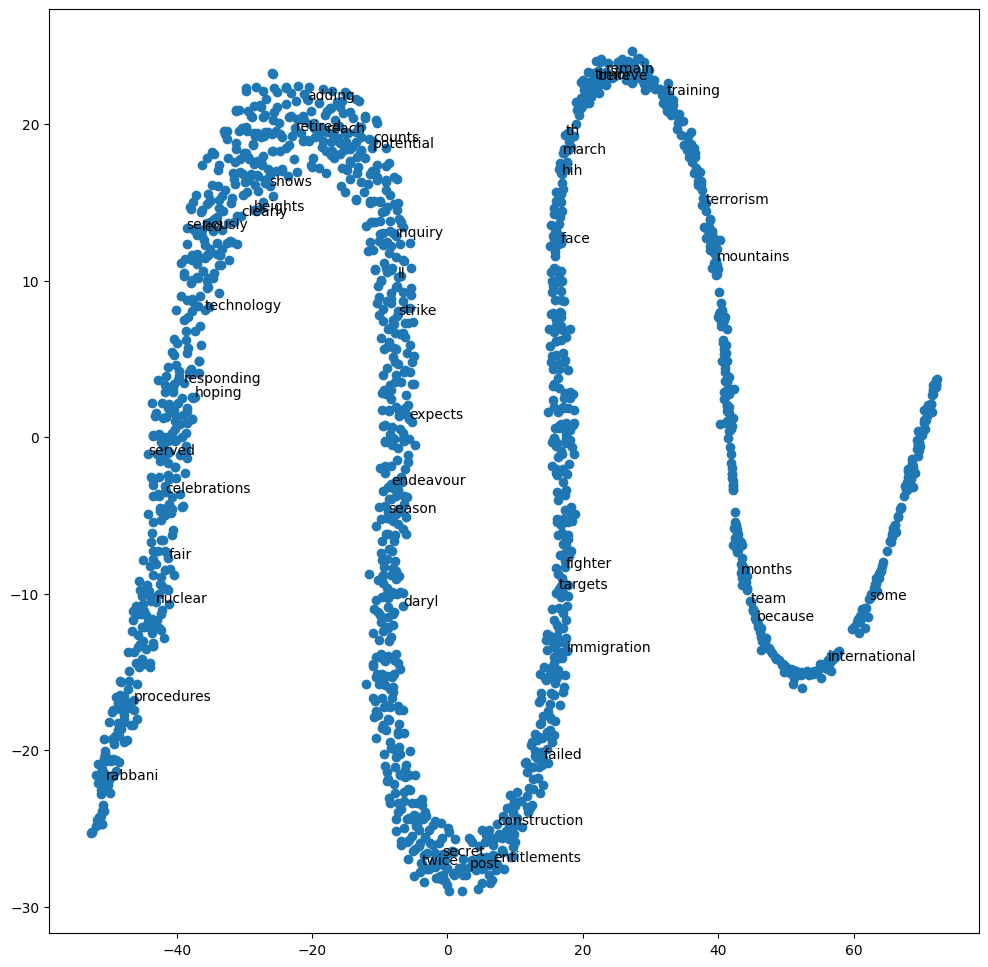

In [24]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model)

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 50)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))


plot_with_matplotlib(x_vals, y_vals, labels)

Conclusion
----------

In this tutorial we learned how to train word2vec models on your custom data
and also how to evaluate it. Hope that you too will find this popular tool
useful in your Machine Learning tasks!

Links
-----

- API docs: :py:mod:`gensim.models.word2vec`
- `Original C toolkit and word2vec papers by Google <https://code.google.com/archive/p/word2vec/>`_.


